# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

# Indice

1. [Introducción](#titulo_principal)
2. [Preparación de datos](#titulo_principal_1)
3. [Entrenamiento de modelos](#titulo_principal_2)
4. [Conclusiones](#titulo_principal_3)


## Introducción<a id="titulo_principal"></a>

En el presente proyecto se realizara un analisis de los datos de una compañia de servicios de transporte (taxis), para que se realizara una limpieza, busqueda de tendencias entre otras metricas.

La finalidad del proyecto es entrenar un modelo que de una metrica RECM menor a 48.

En este proyecto se utilizan Regresiones lineales, Bosque Aleatorio, XGBoost, CatBoost LGBMregression.

In [135]:
# Manipulación de datos
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Modelado
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import time
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

# Evaluación del rendimiento
from sklearn.metrics import mean_squared_error

# Remuestreo de datos
from pandas.tseries.frequencies import to_offset

# Desactivación de advertencias
import warnings
warnings.filterwarnings("ignore")


## Preparación de datos<a id="titulo_principal_1"></a>

In [136]:
# Carga del dataset
df =  pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [137]:
df = df.resample('H').sum()

In [138]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Los datos se muestran cada 10 minutos junto con el número de ordenes en esa temporalidad originalmente, en el anterior codigo se hizo un resample para que este el numero de ordenes por hora

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Veo en general datos limpios, hay que cambiar la columna datetime a tipo date para que sea compatible con la libreria pandas para la manipulación por zonas temporales, esto ya se hizo prevaiemente al cargar el dataset

In [140]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Se observan algunos datos bastante grandes, el 75% de los datos se encuentran por de bajo de 19 ordenes y la media es de 14 ordenes por cada 10 minutos

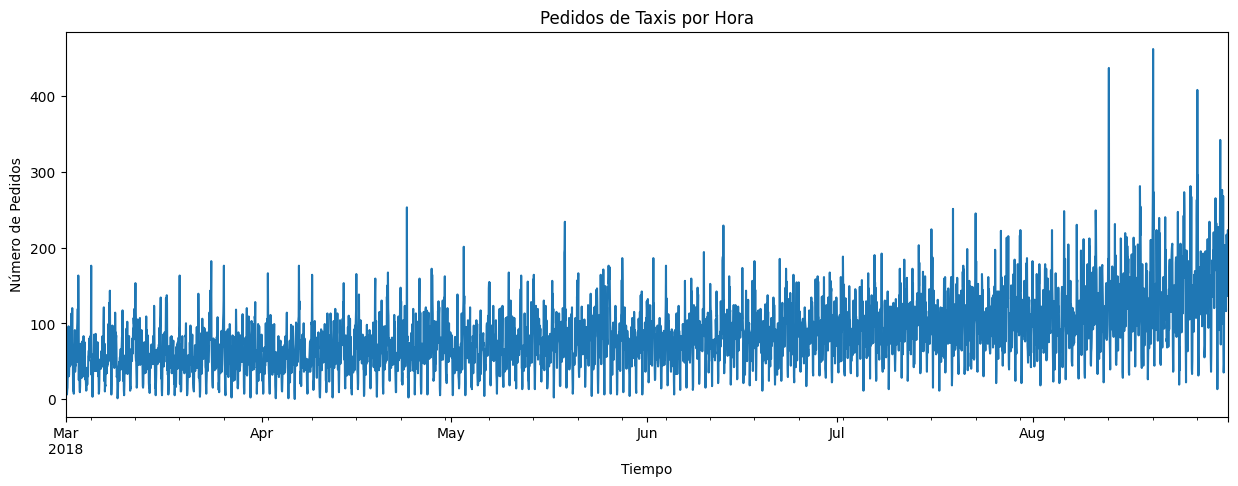

In [141]:
# Graficar la serie temporal de pedidos por hora
df['num_orders'].plot(figsize=(15, 5), title='Pedidos de Taxis por Hora')
plt.xlabel('Tiempo')
plt.ylabel('Número de Pedidos')
plt.show()

In [142]:
min_date = df.index.min()

max_date = df.index.max()

print(min_date)
print(max_date)

2018-03-01 00:00:00
2018-08-31 23:00:00


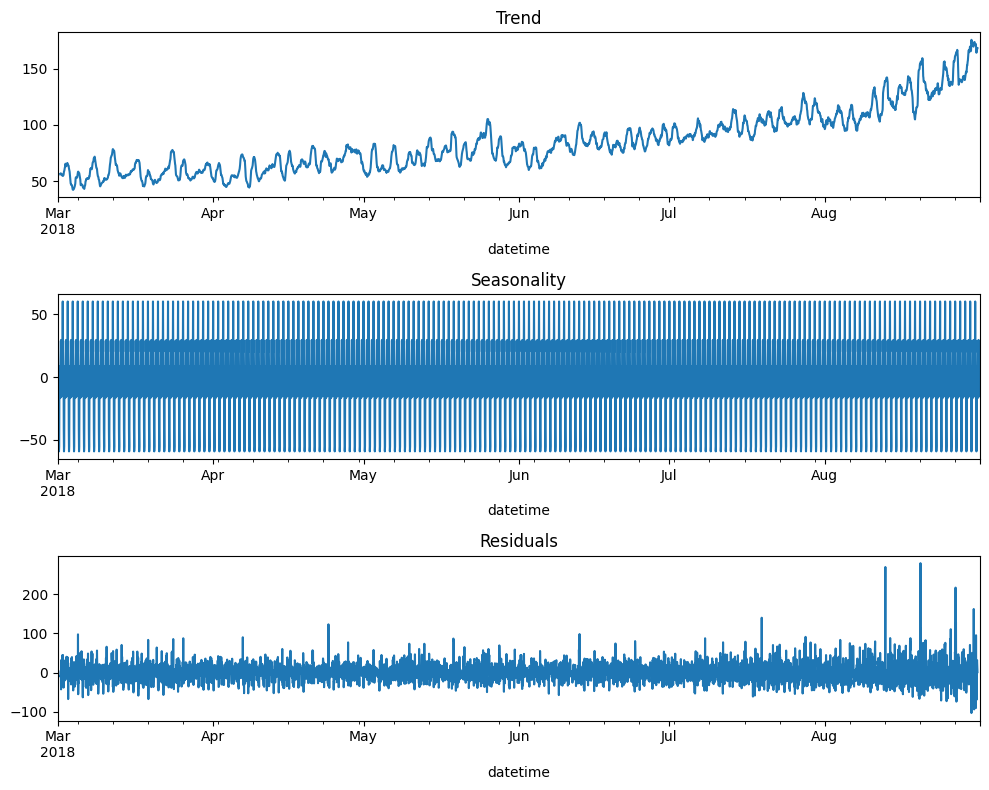

In [143]:
decomposed = seasonal_decompose(df['num_orders'], model='additive')

# Graficar las componentes
plt.figure(figsize=(10, 8))

# Tendencia
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

# Estacionalidad
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

# Residuos
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

Por lo que se puede observar en los graficos anteriores existe una tendencia alcista del numero de pedidos del servicio de taxis haciendo esta descomposición con seasonal_descompose.

A continuación analizare los pedidos del servicio por mes

<Axes: xlabel='datetime'>

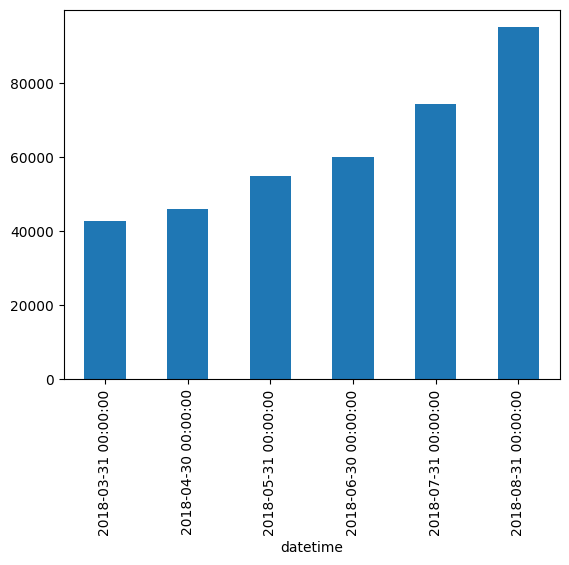

In [144]:
volume_per_month = df['num_orders'].resample('M').sum()

volume_per_month.plot(kind='bar')

En efecto se denota una tencia al alza desde el comienzo de los datos a finales de marzo hasta finales de Agosto

A continuación observare el número dee pedidos por día de la semana.

In [145]:
df_dayofweek = df.copy()

df_dayofweek['dayofweek'] = df.index.dayofweek

volume_per_dayofweek= df_dayofweek.groupby('dayofweek')['num_orders'].sum().reset_index()

# Crear el gráfico interactivo con Plotly
fig = px.bar(volume_per_dayofweek,
             x='dayofweek',
             y='num_orders',
             labels={'dayofweek': 'Day of the Week', 'num_orders': 'Number of Orders'},
             title='Volume of Orders per Day of the Week',
             text='num_orders',
             color_discrete_sequence=['green'])


fig.update_xaxes(
    tickvals=[0, 1, 2, 3, 4, 5, 6],
    ticktext=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Mostrar el gráfico
fig.show()

Los días con mayor demanda son Lunes y Viernes, parece que el día martes cae abruptamente la demanda, esta comienza a ascender tendencialmente hasta el dia Viernes para llegar a su pico y posteriormente descender hasta el día domingo, el peor día es para el Martes.

A continuación realizare un grafico por pedidos por hora

In [146]:
df_hour_graph = df.copy()

df_hour_graph['hour'] = df_hour_graph.index.hour

Orders_by_hour = df_hour_graph.groupby('hour')['num_orders'].sum().reset_index()

# Creción de grafico plotly

fig = px.bar(Orders_by_hour,
             x = 'hour',
             y = 'num_orders',
             labels={'hour': 'Hour of the day', 'num_orders': 'Number of orders'},
             title='Volume of orders by hour in the day',
             text='num_orders',
             color_discrete_sequence=['skyblue']
)

tickvals = list(range(24))
fig.update_xaxes(
    tickvals=tickvals,
    ticktext=[f'{hour}:00' for hour in tickvals]
)

# Mostrar el gráfico
fig.show()

Se observa que en el promedio de días hay una alta demanda en las primeras horas del día y a partir de las 03:00 am derece sustancialmente hasta las 6 donde hay solo 4632 pedidos registrados en esta hora, posteriormente se mantiene constante y aumenta hasta las 10:00 horas y vuelve a crear el 2do pico mas alto a las 16:00 horas se reduce la demanda hasta las 18:00 horas y comienza a ascender hora por hora hasta las 23:00 horas

## Entrenamiento de modelo <a id="titulo_principal_2"></a>

In [180]:
# Adición de caracteristicas 

# Función para crear características
def make_features(data, max_lag, rolling_mean_size, target_column):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data[target_column].shift(lag)

    data['rolling_mean'] = (
        data[target_column].shift().rolling(rolling_mean_size).mean()
    )
    return data
    


In [148]:
# División en conjunto de prueba, validación y entrenamoiento

df_train, df_test = train_test_split(df, shuffle=False, test_size=0.1)


In [149]:
def best_leg_rolling(data_train, data_test, target_column, model, param_dist=None, n_iter=10, random_state=42):
    best_rmse = float('inf')
    best_max_lag = 0
    best_rolling_size = 0
    best_model_params = None

    scaler = MaxAbsScaler()

    # Optimización: precomputar las características
    feature_dict_train = {}
    feature_dict_test = {}

    for max_lag in range(1, 7):
        for rolling_size in range(1, 7):
            df_copy_train = data_train.copy()
            df_copy_test = data_test.copy()

            df_copy_train = make_features(df_copy_train, max_lag, rolling_size, target_column)
            df_copy_test = make_features(df_copy_test, max_lag, rolling_size, target_column)

            df_copy_train = df_copy_train.dropna()
            df_copy_test = df_copy_test.dropna()

            X_train = df_copy_train.drop(target_column, axis=1)
            y_train = df_copy_train[target_column]

            X_test = df_copy_test.drop(target_column, axis=1)
            y_test = df_copy_test[target_column]

            feature_dict_train[(max_lag, rolling_size)] = (X_train, y_train)
            feature_dict_test[(max_lag, rolling_size)] = (X_test, y_test)

    for max_lag in range(1, 7):
        for rolling_size in range(1, 7):
            X_train, y_train = feature_dict_train[(max_lag, rolling_size)]
            X_test, y_test = feature_dict_test[(max_lag, rolling_size)]

            # Escalado de características
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            if isinstance(model, LinearRegression):
                current_model = LinearRegression()
                current_model.fit(X_train_scaled, y_train)
                predictions = current_model.predict(X_test_scaled)
                current_params = None
            else:
                search = RandomizedSearchCV(model, param_dist, n_iter=n_iter, scoring='neg_mean_squared_error', cv=3, random_state=random_state, n_jobs=-1)
                search.fit(X_train_scaled, y_train)
                best_model = search.best_estimator_
                predictions = best_model.predict(X_test_scaled)
                current_params = search.best_params_

            rmse = mean_squared_error(y_test, predictions, squared=False)

            if rmse < best_rmse:
                best_rmse = rmse
                best_max_lag = max_lag
                best_rolling_size = rolling_size
                if current_params is not None:
                    best_model_params = current_params

    if best_model_params is None:
        return best_rmse, best_max_lag, best_rolling_size
    else:
        return best_rmse, best_max_lag, best_rolling_size, best_model_params


In [150]:
# Regresión Lineal 

best_rmse, best_max_lag, best_rolling_size = best_leg_rolling(df_train, df_test, 'num_orders', LinearRegression(), random_state=42)

model_name = 'Regresion Lineal'

print('Para el modelo de {}, el mejor rmse es {}, con el max_lag de {} y la mejor media movil de {}'.format(model_name ,best_rmse, best_max_lag, best_rolling_size))

Para el modelo de Regresion Lineal, el mejor rmse es 52.511927147300746, con el max_lag de 3 y la mejor media movil de 2


In [151]:
# Bosque aleatorio 

param_dist = {
    'n_estimators': [10,100,500],
    'max_depth': [5,10,20],
    'min_samples_split': [3,5],
    'min_samples_leaf': [3,5,10] 
}

best_rmse, best_max_lag, best_rolling_size, best_model_params = best_leg_rolling(
    df_train,
    df_test, 
    'num_orders', 
    RandomForestRegressor(random_state=42), 
    param_dist  
)

print(f'El mejor RMSE es {best_rmse:.2f}, con un max_lag de {best_max_lag} y una media móvil de {best_rolling_size}.')
print(f'Mejores hiperparámetros del modelo: {best_model_params}')



El mejor RMSE es 45.25, con un max_lag de 6 y una media móvil de 4.
Mejores hiperparámetros del modelo: {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 20}


In [152]:
# LGBMRegressor

param_dist = {
    'n_estimators': [15, 25, 50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [10, 20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

best_rmse, best_max_lag, best_rolling_size, best_model_params = best_leg_rolling(
    df_train,
    df_test, 
    'num_orders', 
    LGBMRegressor(random_state=12345), 
    param_dist  
)

print(f'El mejor RMSE es {best_rmse:.2f}, con un max_lag de {best_max_lag} y una media móvil de {best_rolling_size}.')
print(f'Mejores hiperparámetros del modelo: {best_model_params}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 3973, number of used features: 6
[LightGBM] [Info] Start training from score 78.279134
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 3972, number of used features: 6
[LightGBM] [Info] Start training from score 78.277442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 397

In [153]:
# XGBoost

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [0.01, 1]
}

best_rmse, best_max_lag, best_rolling_size, best_model_params = best_leg_rolling(
    df_train,
    df_test, 
    'num_orders', 
    XGBRegressor(random_state=12345), 
    param_dist  
)

print(f'El mejor RMSE es {best_rmse:.2f}, con un max_lag de {best_max_lag} y una media móvil de {best_rolling_size}.')
print(f'Mejores hiperparámetros del modelo: {best_model_params}')


El mejor RMSE es 40.78, con un max_lag de 4 y una media móvil de 3.
Mejores hiperparámetros del modelo: {'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}


In [154]:
# CatBoost

param_dist = {
    'iterations': [15, 25, 50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 50, 100, 200]
}


best_rmse, best_max_lag, best_rolling_size, best_model_params = best_leg_rolling(
    df_train,
    df_test, 
    'num_orders', 
    CatBoostRegressor(random_state=12345), 
    param_dist  
)

print(f'El mejor RMSE es {best_rmse:.2f}, con un max_lag de {best_max_lag} y una media móvil de {best_rolling_size}.')
print(f'Mejores hiperparámetros del modelo: {best_model_params}')

0:	learn: 37.3014265	total: 2.43ms	remaining: 726ms
1:	learn: 35.6302910	total: 4.06ms	remaining: 605ms
2:	learn: 34.2161660	total: 4.94ms	remaining: 490ms
3:	learn: 33.0723182	total: 5.79ms	remaining: 429ms
4:	learn: 32.0900990	total: 6.57ms	remaining: 387ms
5:	learn: 31.3205376	total: 7.33ms	remaining: 359ms
6:	learn: 30.6195684	total: 8.26ms	remaining: 346ms
7:	learn: 29.8982506	total: 9.36ms	remaining: 341ms
8:	learn: 29.2078661	total: 10.1ms	remaining: 325ms
9:	learn: 28.8937459	total: 10.8ms	remaining: 313ms
10:	learn: 28.4205612	total: 11.5ms	remaining: 302ms
11:	learn: 27.9330910	total: 12.2ms	remaining: 292ms
12:	learn: 27.5093594	total: 12.8ms	remaining: 283ms
13:	learn: 27.2200676	total: 13.7ms	remaining: 280ms
14:	learn: 26.8524924	total: 15ms	remaining: 285ms
15:	learn: 26.5526620	total: 15.9ms	remaining: 283ms
16:	learn: 26.3857728	total: 16.8ms	remaining: 280ms
17:	learn: 26.1703828	total: 17.6ms	remaining: 276ms
18:	learn: 26.0196384	total: 18.4ms	remaining: 272ms
19:	l

In [246]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Definición del modelo con los mejores hiperparámetros encontrados
best_model = XGBRegressor(random_state=12345, subsample=0.8, reg_lambda=0.01, reg_alpha=0.5, n_estimators=300, min_child_weight=5, max_depth=3, learning_rate=0.1, gamma=0, colsample_bytree=1)


# Creación de las características de entrenamiento y prueba
df_copy_train = df_train.copy()
df_copy_test = df_test.copy()

df_copy_train = make_features(df_copy_train, 4, 3, 'num_orders')
df_copy_test = make_features(df_copy_test, 4, 3, 'num_orders')

df_copy_train = df_copy_train.dropna()
df_copy_test = df_copy_test.dropna()

X_train = df_copy_train.drop('num_orders', axis=1)
y_train = df_copy_train['num_orders']

X_test = df_copy_test.drop('num_orders', axis=1)
y_test = df_copy_test['num_orders']

# Entrenamiento del modelo
best_model.fit(X_train, y_train)

# Predicciones y cálculo del RMSE
predictions = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(predictions, y_test))
print(f"RMSE: {rmse}")




RMSE: 40.784867202604026


In [256]:
# Crear dataframe para plotly express
df_plot = pd.DataFrame({
    'Fecha': y_test.index,
    'Valores_Reales': y_test.values,
    'Predicciones': predictions
})

# Crear gráfico interactivo con Plotly Express
fig = px.scatter(df_plot, 
                 x='Fecha', 
                 y=['Valores_Reales', 'Predicciones'], 
                 labels={'Fecha': 'Fecha y Hora', 'value': 'Número de Órdenes'},
                 color_discrete_sequence=['blue', 'red'])

fig.update_layout(title='Comparación de Predicciones y Valores Reales',
                  xaxis_title='Fecha y Hora',
                  yaxis_title='Número de Órdenes',
                  legend_title='Datos',
                  hovermode='x unified')

fig.show()

from scipy.stats import pearsonr

# Calcular correlación de Pearson entre predicciones y valores reales
correlation, _ = pearsonr(predictions, y_test)
print(f"Correlación de Pearson: {correlation}")

Correlación de Pearson: 0.7238395111147611


## Conclusión <a id="titulo_principal_3"></a>

En este proyecto se realizo unn analisis exploratorio de datos y de visualización para una empresa de servicios de transporte de taxis en la que se concluyeron los siguientes puntos:

- La tendencia general de los pedidos por servicios de taxi tienen una tendencia al alza
- A las ultimas y primeras horas del día se encuentra una alta demanda que baja alrededor de las 6:00 horas y repunta hasta las 16:00 horas
- El mejor modelo fue el XGBoost seguido del CatBoost, aunque este ultimo tiene una mayor tiempo de entrenamiento
- En el grafico anterior entre las predicciones y los datos reales del conjunto de testing, hay una fuerte correlación del 0.7238


**Conclusión final**
A la vista posterior de entrenar y evaluar los modelos con la metrica RECM podemos observa que XGBoost es extremadamente superior a los demás en terminos tanto de velocidad de entrenamiento como en calidad de predicción, se pudo observar un RMSE de: 40.784867202604026, bastante bueno para el objetivo que se había marcado previamente (RECM = 48)

    max_lag de 4 y una media móvil de 3.
    Mejores hiperparámetros del modelo: {'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0